# Import library

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import zhconv

In [162]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
from snownlp import SnowNLP
import openpyxl

# Import dataset

In [163]:
df = pd.read_csv(r'D:\Berry\商赛\CBSA\ust_risk_data.csv')

In [164]:
df.shape

(1226271, 21)

In [165]:
df.columns

Index(['docid', 'comment_count', 'like_count', 'dislike_count', 'love_count',
       'haha_count', 'wow_count', 'angry_count', 'sad_count', 'share_count',
       'view_count', 'emoji_count', 'headline', 'content', 'md5(author)',
       'pubname', 'pubcode', 'pubtype', 'pubdate', 'region', 'fans_count'],
      dtype='object')

## Data preprocessing

In [166]:
data = df.copy()

In [167]:
# Remove duplicate data
data.drop_duplicates(inplace=True)
# Handle missing values
data.dropna(inplace=True)
data.shape  # Data dimensions after data preprocessing

(38857, 21)

In [168]:
# Remove stop words
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    """
    string = re.sub(r"[^\u4e00-\u9fa5_A-Za-z0-9]", " ", string)
    string = re.sub(r"\'s", " 's", string)
    string = re.sub(r"\'ve", " 've", string)
    string = re.sub(r"n\'t", " n't", string)
    string = re.sub(r"\'re", " 're", string)
    string = re.sub(r"\'d", " 'd", string)
    string = re.sub(r"\'ll", " 'll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = zhconv.convert(string, "zh-hans")  # Convert to simplified Chinese

    return string.strip().lower()

# Preprocess titles and content
data["processed_headline"] = data["headline"].apply(clean_str)
data["processed_content"] = data["content"].apply(clean_str)
data["processed_pubname"] = data["pubname"].apply(clean_str)

In [169]:
# 定义碧桂园相关关键词-Chinese
country_garden_keywords = ["碧桂园"]

# Define Country Garden related keywords-English
country_garden_keywords_english = [
    "Country Garden",
    "country garden",
    "countrygarden",
    "CountryGarden",
    "Countrygarden",
]

# Determine whether the text contains Country Garden keywords
data["country_garden_related"] = data["processed_content"].apply(
    lambda x: any(keyword in x for keyword in country_garden_keywords)
)

# Determine whether the text contains Country Garden keywords-English
data["country_garden_related_english"] = data["processed_content"].apply(
    lambda x: any(keyword in x for keyword in country_garden_keywords_english)
)

In [170]:
print(data["country_garden_related"].value_counts())  # Statistics describing the number of Country Garden news
print(data["country_garden_related_english"].value_counts())  # Statistics describing the number of Country Garden news

country_garden_related
False    38564
True       293
Name: count, dtype: int64
country_garden_related_english
False    38835
True        22
Name: count, dtype: int64


Since that the english news is only 22, we mainly focus on Chinese news. And we can use the same method to analyse english news if it's needed in other cases.

In [171]:
# Filter news containing Country Garden keywords
country_garden_news = data[data["country_garden_related"]]
country_garden_news.shape

(293, 26)

In [172]:
features = [
    "docid",
    "comment_count",
    "like_count",
    "dislike_count",
    "love_count",
    "haha_count",
    "wow_count",
    "angry_count",
    "sad_count",
    "share_count",
    "view_count",
    "emoji_count",
    "md5(author)",
    "pubcode",
    "pubtype",
    "pubdate",
    "region",
    "fans_count",
    "processed_headline",
    "processed_content",
    "processed_pubname",
]

In [173]:
country_garden_dataset = country_garden_news[features]
country_garden_dataset = country_garden_dataset.reset_index()

# time series analysis

In [174]:
# Convert 'pubdate' column to datetime type
country_garden_dataset["pubdate"] = pd.to_datetime(country_garden_dataset["pubdate"])

In [189]:
country_garden_dataset["year"] = country_garden_dataset["pubdate"].dt.year
country_garden_dataset["month"] = country_garden_dataset["pubdate"].dt.month
country_garden_dataset

,index,docid,comment_count,like_count,dislike_count,love_count,haha_count,wow_count,angry_count,sad_count,...,pubtype,pubdate,region,fans_count,processed_headline,processed_content,processed_pubname,year,month,day
0,4757,2021100500002433113,46.0,228.0,0.0,9.0,219.0,49.0,1.0,3.0,...,C,2021-10-05 08:39:13,Hong Kong,130000.0,花样年未能如期还债 碧桂园服务执行股份质押转让 内房债务危机浮现 中国房地产开发商花样年控股...,花样年未能如期还债碧桂园服务执行股份质押转让 内房债务危机浮现 中国房地产开发商花样年控股 ...,facebook香港,2021,10,5
1,4807,2021100500002896328,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,C,2021-10-05 08:50:29,Hong Kong,9300.0,市传合生以400亿买入51 恒大物业 个市无端端又插500 10天线一失守后急转直下 其实又...,市传合生以400亿买入51 恒大物业 个市无端端又插500 10天线一失守后急转直下 其实又...,facebook香港,2021,10,5
2,5117,2021100500005073984,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2021-10-05 13:31:38,Hong Kong,19449.0,marketfocus hk 火烧连环船 花样年16亿美元债违约 停牌濒爆煲 内房股全面暴跌...,marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...,instagram香港,2021,10,5
3,5185,2021100500005701823,6.0,407.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2021-10-05 13:30:37,Hong Kong,185894.0,marketfocus hk 火烧连环船 花样年16亿美元债违约 停牌濒爆煲 内房股全面暴跌...,marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...,instagram香港,2021,10,5
4,5305,2021100500006330705,0.0,10.0,0.0,1.0,0.0,2.0,0.0,0.0,...,C,2021-10-05 14:40:23,Hong Kong,8500.0,华南五虎 隐形地产航母 出手救恒大 若干年前 有五家发轫于中国广东的房地产公司曾被称作 华南...,华南五虎 隐形地产航母出手救恒大 若干年前 有五家发轫于中国广东的房地产公司曾被称作 华南五...,facebook香港,2021,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1213946,2023092321787668834,0.0,2907.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2023-09-23 22:22:47,Hong Kong,181000.0,恒大宣布放弃重组美元债 黑洞级债务一早知系无解 依家中国债务危机将会无序解决 外资走得更快中...,evergrande 中国 许家印 00 00恒大宣布放弃重组美元债黑洞级债务一早知系无解 ...,youtube 香港,2023,9,23
289,1216361,2023092521782388082,0.0,134.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2023-09-25 20:01:01,Hong Kong,140000.0,今日读报时间 中国防长不好当 李尚福凶多吉少 全球加息周期已经结束 中国房地产危机拉响新警报...,订阅杨锦麟频道 每天免费收看最新影片 欢迎各位透过超级感谢支持我们的创作 亦可通过paypa...,youtube 香港,2023,9,25
290,1220617,2023092721776776883,3.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2023-09-27 12:00:00,Hong Kong,287000.0,龚成问答信箱 q33121 q33140 q33121 龚sir 我现年31岁 我几个月前投...,龚成问答信箱 q33121 q33140 q33121 龚sir 我现年31岁 我几个月前投...,facebook 香港,2023,9,27
291,1223537,2023092821787357721,10.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,...,C,2023-09-28 21:00:00,Hong Kong,287000.0,龚成问答信箱 q33141 q33160 q33141 1 你好 我今年53岁 我想问买入以...,龚成问答信箱 q33141 q33160 q33141 1 你好 我今年53岁 我想问买入以...,facebook 香港,2023,9,28


In [176]:
print(country_garden_dataset["processed_content"])

0      花样年未能如期还债碧桂园服务执行股份质押转让 内房债务危机浮现 中国房地产开发商花样年控股 ...
1      市传合生以400亿买入51 恒大物业 个市无端端又插500 10天线一失守后急转直下 其实又...
2      marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...
3      marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...
4      华南五虎 隐形地产航母出手救恒大 若干年前 有五家发轫于中国广东的房地产公司曾被称作 华南五...
                             ...                        
288    evergrande 中国 许家印 00 00恒大宣布放弃重组美元债黑洞级债务一早知系无解 ...
289    订阅杨锦麟频道 每天免费收看最新影片 欢迎各位透过超级感谢支持我们的创作 亦可通过paypa...
290    龚成问答信箱 q33121 q33140 q33121 龚sir 我现年31岁 我几个月前投...
291    龚成问答信箱 q33141 q33160 q33141 1 你好 我今年53岁 我想问买入以...
292    2023年8月21日新加坡 联合早报 评论文章 问题在经济根子在政治刘梦熊 当前中国经济面临...
Name: processed_content, Length: 293, dtype: object


In [177]:
import math
from snownlp import SnowNLP
import pandas as pd
import datetime, traceback
import json

In [178]:
row = country_garden_dataset.loc[0].to_dict()
country_garden_dataset["month"]

0      10
1      10
2      10
3      10
4      10
       ..
288     9
289     9
290     9
291     9
292     9
Name: month, Length: 293, dtype: int32

In [179]:
def calculate_sentiment_scores(dataset, year, month):
    pos = 0
    neg = 0
    pos_count = 0
    neg_count = 0

    for i in range(0, len(dataset)):
        comment = dataset.loc[i].to_dict()
        # print(year)
        # print(month)
        year_1 = comment["year"]
        month_1 = comment["month"]

        processed_content = comment["processed_content"]
        like_count = comment["like_count"]
        dislike_count = comment["dislike_count"]
        fans_count = comment["fans_count"]
        love_count = comment["love_count"]
        haha_count = comment["haha_count"]
        wow_count = comment["wow_count"]
        angry_count = comment["angry_count"]
        sad_count = comment["sad_count"]
        # print("year:", year_1, " month:", month_1)
        if year_1 == year and month_1 == month:
            try:
                nlp = SnowNLP(processed_content)
                sentiment_score = nlp.sentiments
            except:
                print(traceback.format_exc())
                continue
            # print(sentiment_score)
            if sentiment_score > 0.6:
                pos_count += 1
                pos += 1 + math.log(like_count - dislike_count + fans_count + love_count + haha_count + wow_count - angry_count - sad_count + 1, 2)
            elif sentiment_score < 0.4:
                neg_count += 1
                neg += 1 + math.log(like_count - dislike_count + fans_count + love_count + haha_count + wow_count - angry_count - sad_count + 1, 2)
        score = pos / (pos + neg + 0.000000001) + 0.5

    return pos, neg, score


pos, neg, score = calculate_sentiment_scores(country_garden_dataset, 2021, 11)
pos, neg, score

(133.5007407302707, 32.81235633389328, 1.3027073218290386)

In [180]:


# Create a new workbook and select the active sheet
workbook = openpyxl.Workbook()
sheet = workbook.active

# Write the headers
sheet['A1'] = 'Year'
sheet['B1'] = 'Month'
sheet['C1'] = 'Score'

# Initialize the row counter
row = 2

# Iterate over the years and months
for year in range(2021, 2024):
    for month in range(1, 13):
        if year == 2023 and month > 9:
            break

        # Calculate sentiment scores
        pos, neg, score = calculate_sentiment_scores(country_garden_dataset, year, month)

        # Write the data to the sheet
        sheet.cell(row=row, column=1, value=year)
        sheet.cell(row=row, column=2, value=month)
        sheet.cell(row=row, column=3, value=score)

        # Increment the row counter
        row += 1

# Save the workbook to a file
workbook.save('D:\Berry\商赛\CBSA\sentiment_scores.xlsx')

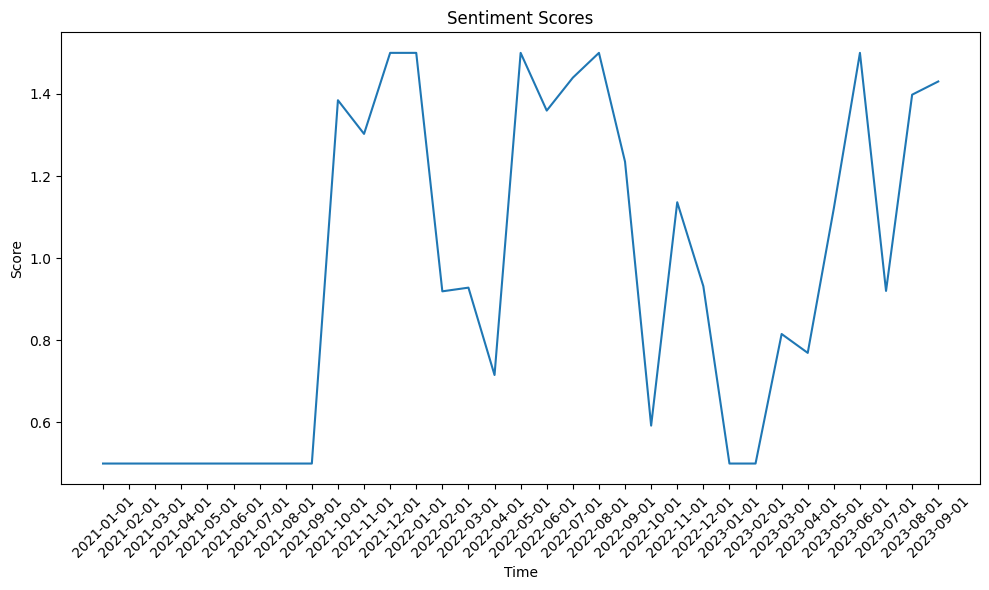

In [181]:
# Load the data from the Excel file
workbook = openpyxl.load_workbook('D:\Berry\商赛\CBSA\sentiment_scores.xlsx')
sheet = workbook.active

# Initialize lists to store the data
years = []
months = []
scores = []

# Read the data from the sheet
for row in sheet.iter_rows(min_row=2, values_only=True):
    year, month, score = row
    years.append(year)
    months.append(month)
    scores.append(score)

# Convert years and months to datetime objects
dates = [str(year) + '-' + str(month).zfill(2) + '-01' for year, month in zip(years, months)]
plt.figure(figsize=(10, 6))
# Plot the data
plt.plot(dates, scores)
plt.xlabel('Time')
plt.ylabel('Score')
plt.title('Sentiment Scores')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

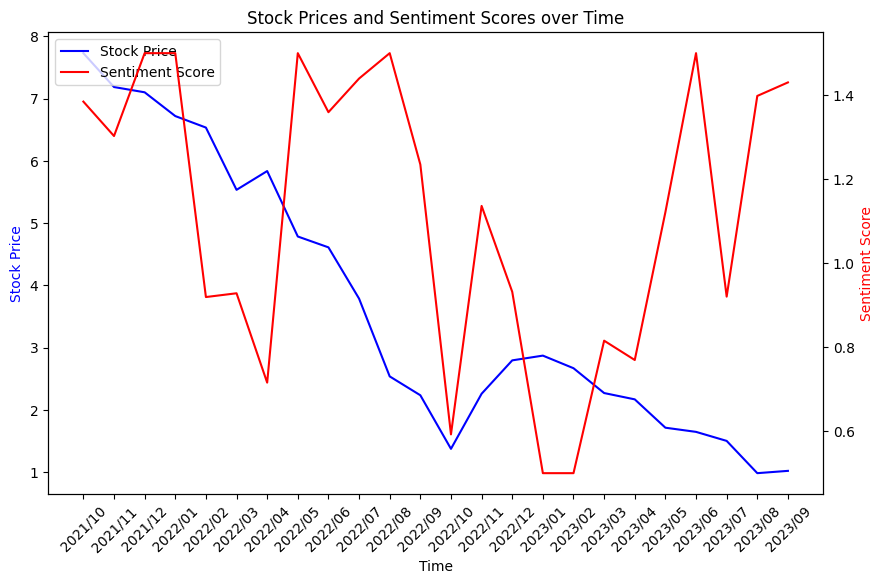

In [182]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
data = pd.read_excel(r"D:\Berry\商赛\CBSA\stock_sentiment_scores.xlsx")

# Extract the columns
dates = data['date']
stock_prices = data['stock_price']
sentiment_scores = data['sentiment score']

# Create the figure and axes objects
fig, ax1 = plt.subplots()

# Plot the stock prices on the left y-axis
ax1.plot(dates, stock_prices, color='blue', label='Stock Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price', color='blue')

# Create the second y-axis for sentiment scores
ax2 = ax1.twinx()
ax2.plot(dates, sentiment_scores, color='red', label='Sentiment Score')
ax2.set_ylabel('Sentiment Score', color='red')

# Show legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Set the rotation angle for x-axis tick labels
ax1.tick_params(axis='x', rotation=45)

# Set the plot title
plt.title('Stock Prices and Sentiment Scores over Time')

# Set the size of the figure
fig.set_size_inches(10, 6)  # Set the width to 10 inches and height to 6 inches

# Display the plot
plt.show()

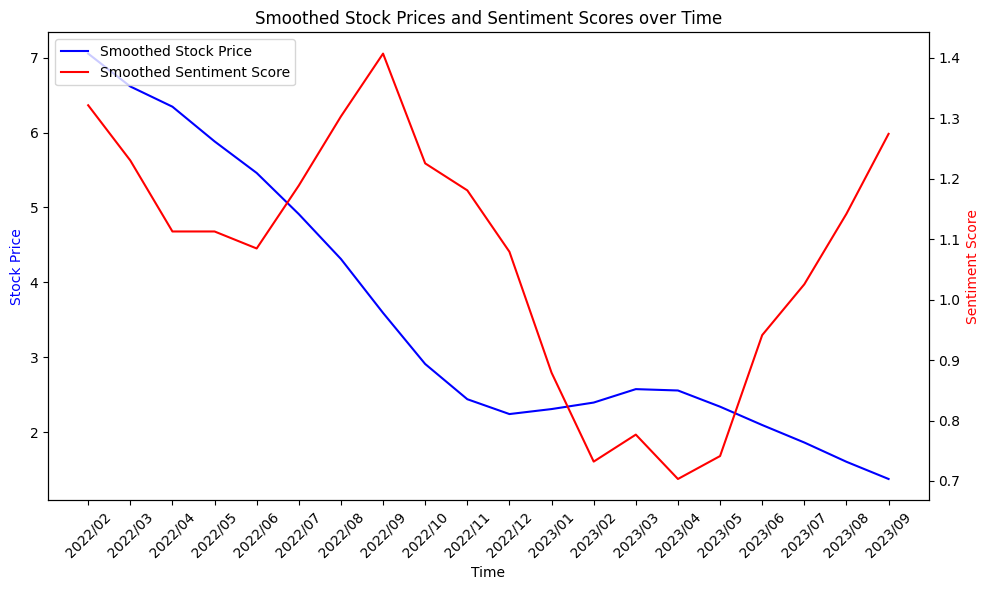

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the Excel file
data = pd.read_excel(r"D:\Berry\商赛\CBSA\stock_sentiment_scores.xlsx")

# Extract the columns
dates = data['date']
stock_prices = data['stock_price']
sentiment_scores = data['sentiment score']

# Set the window size for the moving average
window_size = 5

# Calculate the moving averages
smoothed_stock_prices = stock_prices.rolling(window=window_size).mean()
smoothed_sentiment_scores = sentiment_scores.rolling(window=window_size).mean()

# Create the figure and axes objects
fig, ax1 = plt.subplots()

# Plot the smoothed stock prices on the left y-axis
ax1.plot(dates, smoothed_stock_prices, color='blue', label='Smoothed Stock Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Stock Price', color='blue')

# Create the second y-axis for smoothed sentiment scores
ax2 = ax1.twinx()
ax2.plot(dates, smoothed_sentiment_scores, color='red', label='Smoothed Sentiment Score')
ax2.set_ylabel('Sentiment Score', color='red')

# Show legend for both lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Rotate and align the x-axis labels
ax1.tick_params(axis='x', rotation=45)

# Set the plot title
plt.title('Smoothed Stock Prices and Sentiment Scores over Time')
# Set the size of the figure
fig.set_size_inches(10, 6)  # Set the width to 10 inches and height to 6 inches

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [187]:
# Calculate the correlation coefficient
correlation = smoothed_stock_prices.corr(smoothed_sentiment_scores)

print("Correlation coefficient: ", correlation)

Correlation coefficient:  0.41747968152956905


# prediction model

1. Define a binary classification problem:

First, the target_binary variable is generated to indicate whether a potential risk or event occurs. It can be based on a certain threshold. For example, if the number of comments or likes exceeds a certain threshold, it will be 1 (an influential event), otherwise it will be 0 (not an influential event).

In [96]:
features = [
    "docid",
    "comment_count",
    "like_count",
    "dislike_count",
    "love_count",
    "haha_count",
    "wow_count",
    "angry_count",
    "sad_count",
    "share_count",
    "view_count",
    "emoji_count",
    "md5(author)",
    "pubcode",
    "pubtype",
    "pubdate",
    "region",
    "fans_count",
    "processed_headline",
    "processed_content",
    "processed_pubname",
]

country_garden_dataset = country_garden_news[features]
country_garden_dataset = country_garden_dataset.reset_index()

,index,docid,comment_count,like_count,dislike_count,love_count,haha_count,wow_count,angry_count,sad_count,...,emoji_count,md5(author),pubcode,pubtype,pubdate,region,fans_count,processed_headline,processed_content,processed_pubname
0,4757,2021100500002433113,46.0,228.0,0.0,9.0,219.0,49.0,1.0,3.0,...,4.0,dfc3cd285b013e8938580ac2a60bb34c,blog_m_facebookhk_hk,C,2021-10-05 08:39:13,Hong Kong,130000.0,花样年未能如期还债 碧桂园服务执行股份质押转让 内房债务危机浮现 中国房地产开发商花样年控股...,花样年未能如期还债碧桂园服务执行股份质押转让 内房债务危机浮现 中国房地产开发商花样年控股 ...,facebook香港
1,4807,2021100500002896328,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,b6b44023a6197c7ae3f3b1a15fff7e4d,blog_m_facebookhk_hk,C,2021-10-05 08:50:29,Hong Kong,9300.0,市传合生以400亿买入51 恒大物业 个市无端端又插500 10天线一失守后急转直下 其实又...,市传合生以400亿买入51 恒大物业 个市无端端又插500 10天线一失守后急转直下 其实又...,facebook香港
2,5117,2021100500005073984,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3e0ed3c000443f21b75851f0ebb4bad9,im_instagram_hk,C,2021-10-05 13:31:38,Hong Kong,19449.0,marketfocus hk 火烧连环船 花样年16亿美元债违约 停牌濒爆煲 内房股全面暴跌...,marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...,instagram香港
3,5185,2021100500005701823,6.0,407.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3ec579f8abf797c35a3b7c4def0b2f2f,im_instagram_hk,C,2021-10-05 13:30:37,Hong Kong,185894.0,marketfocus hk 火烧连环船 花样年16亿美元债违约 停牌濒爆煲 内房股全面暴跌...,marketfocus hk 火烧连环船 花样年16亿美元债违约停牌濒爆煲内房股全面暴跌5至...,instagram香港
4,5305,2021100500006330705,0.0,10.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,8edbbb666d6338a1ca5430e6280f7add,blog_m_facebookhk_hk,C,2021-10-05 14:40:23,Hong Kong,8500.0,华南五虎 隐形地产航母 出手救恒大 若干年前 有五家发轫于中国广东的房地产公司曾被称作 华南...,华南五虎 隐形地产航母出手救恒大 若干年前 有五家发轫于中国广东的房地产公司曾被称作 华南五...,facebook香港


In [97]:
country_garden_dataset["like_count"].describe()

count     293.000000
mean      182.481229
std       424.354131
min         0.000000
25%         5.000000
50%        41.000000
75%       190.000000
max      3354.000000
Name: like_count, dtype: float64

In [98]:
country_garden_dataset["comment_count"].describe()

count    293.000000
mean       8.498294
std       26.647319
min        0.000000
25%        0.000000
50%        1.000000
75%        6.000000
max      350.000000
Name: comment_count, dtype: float64

In [132]:
threshold_like_count = 190.000000
threshold_comment_count = 6.000000

In [133]:
# # Then it is 1 (an influential event), otherwise it is 0 (not an influential event).
country_garden_dataset["target_binary"] = (
    country_garden_dataset["comment_count"] > threshold_comment_count
) | (country_garden_dataset["like_count"] > threshold_like_count)
# Convert Boolean values to 0 and 1
country_garden_dataset["target_binary"] = country_garden_dataset["target_binary"].astype(int)

In [134]:
country_garden_dataset["target_binary"].value_counts()

target_binary
0    177
1    116
Name: count, dtype: int64

## Training data set generation

In [135]:
train_features = ["processed_headline", "processed_content", "processed_pubname"]
target_feature = ["target_binary"]

In [136]:
# Merge the processed text data
country_garden_dataset["merged_text"] = (
    country_garden_dataset["processed_headline"]
    + " "
    + country_garden_dataset["processed_content"]
    + " "
    + country_garden_dataset["processed_pubname"]
)


# Chinese word segmentation
def chinese_segmentation(text):
    seg_result = jieba.cut(text)
    stop_words = ["的", "了", "是","我","你","他","她","它","我们","你们","他们","她们","它们","在","于","和","与","也","及","及其", "与其", "是不是", "是否", "因为", "所以", "但是", "然而", "但", "这", "那", "这个", "那个",
    ]
    # Filter out spaces and stop words
    filtered_result = [word for word in seg_result if word.strip() and word not in stop_words]
    return " ".join(filtered_result)


country_garden_dataset["merged_text_segmented"] = country_garden_dataset["merged_text"].apply(
    chinese_segmentation
)

In [139]:
# Remove the sample with the missing target value
country_garden_dataset = country_garden_dataset.dropna(subset=["target_binary"])

# TF-IDF vectorize
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(country_garden_dataset["merged_text_segmented"])
y = country_garden_dataset["target_binary"]

In [140]:
X.shape, y.shape

((293, 18317), (293,))

In [141]:
# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Random forest model

In [142]:
from sklearn.metrics import classification_report

In [143]:
# Create a random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [144]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0])

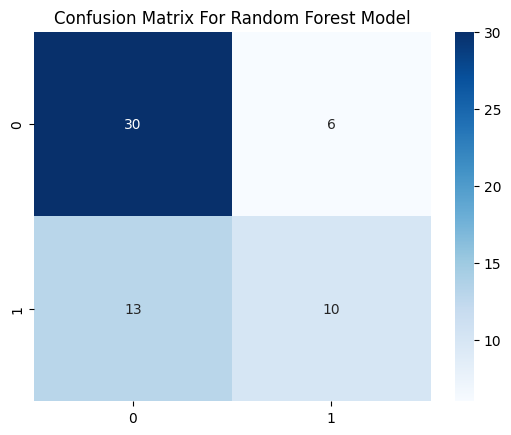

In [145]:
# Confusion matrix:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix For Random Forest Model")
plt.show()

In [146]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        36
           1       0.62      0.43      0.51        23

    accuracy                           0.68        59
   macro avg       0.66      0.63      0.64        59
weighted avg       0.67      0.68      0.66        59



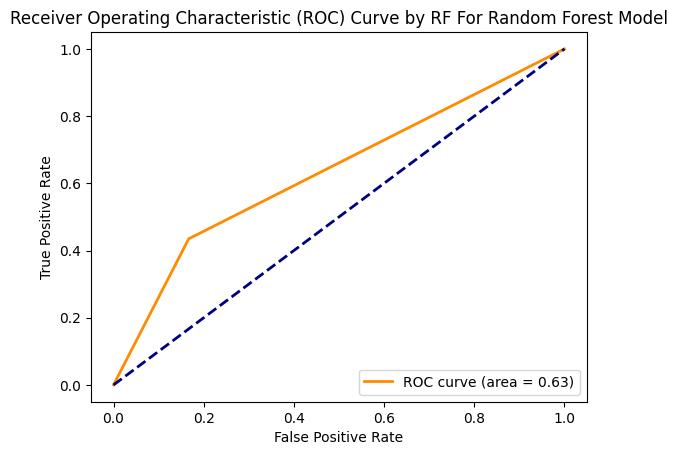

In [147]:
# ROC curve and AUC, used for performance evaluation of binary classification problems.
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = {:.2f})".format(roc_auc),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve by RF For Random Forest Model")
plt.legend(loc="lower right")
plt.show()

In [148]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6779661016949152


## XGBoost model

In [149]:
from xgboost import XGBClassifier

In [150]:
# create XGBoost model
xgb_model = XGBClassifier(
    learning_rate=0.2, n_estimators=100, max_depth=3, random_state=30
)

# train model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=30, ...)

In [151]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0])

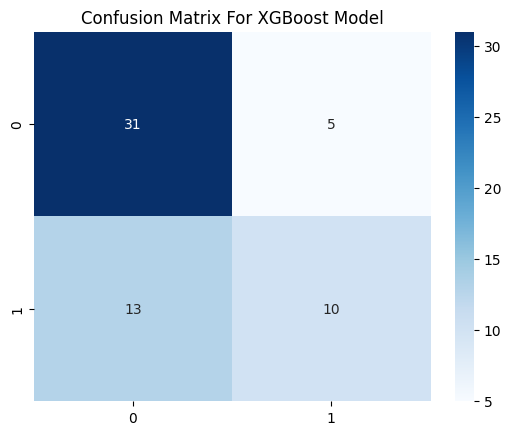

In [152]:
# Confusion matrix (providing model precision, recall, accuracy and other information)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix For XGBoost Model")
plt.show()

In [153]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.70      0.86      0.78        36
           1       0.67      0.43      0.53        23

    accuracy                           0.69        59
   macro avg       0.69      0.65      0.65        59
weighted avg       0.69      0.69      0.68        59



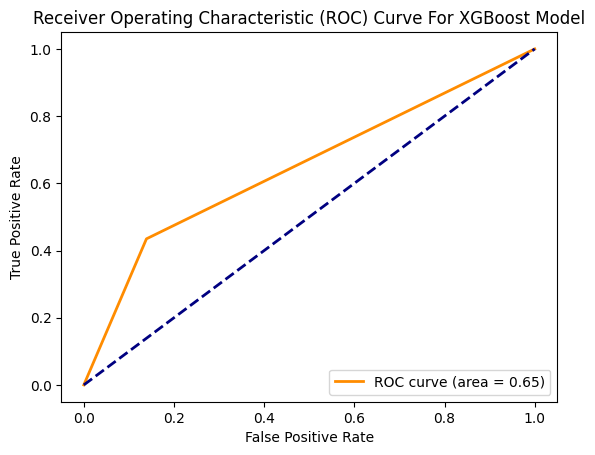

In [154]:
# ROC curve and AUC for performance evaluation of binary classification problems.
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = {:.2f})".format(roc_auc),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve For XGBoost Model")
plt.legend(loc="lower right")
plt.show()

In [156]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6949152542372882


In [157]:
text_content = " 香港大声公 sharedpost 骆惠宁落区访民情听民意传达的重要信息 在房屋和发展问题上 中央当然会一如既往的支持香港 支持香港青年 包括推出多项支持青年北上的政策 但关键始终是特区政府的积极有为 迎难而上 骆主任这次落区与香港同行 起到很好的带头作用 推动各界团结一心 携手解决香港的深层次矛盾 共同开拓更美好的未来 作者 方靖之 香港中联办主任骆惠宁在国庆日前夕再次深入基层 先后走访慰问香港渔民 创业青年 社区居民 临街商铺和 笼屋 住户 传递中央对香港基层民生的关心关注 听取意见建议 并向他们致以诚挚祝福 骆主任落区通过亲身接触和沟通 了解市民的困难和要求 这本来就是中联办积极履行职责的表现 同时也体现中央关心香港经济民生 关注基层市民呼声 彰显 以人民为中心 理念 彰显 以人民为中心 理念更重要的是 骆主任这次落区传达出三个重要信息 一是体现中央支持香港发展新动力 新空间 为各行各业开拓机遇 为青年发展 架桥 搭梯 特区政府和社会各界都必须抓紧机遇 开拓发展空间 二是点出房屋问题是香港最大的民生问题 也是最大的政治问题 特区政府必须拿出决心和承担 解决市民安居问题 三是中联办积极落区与市民同行 起着带头和示范作用 推动爱国爱港阵营必须将市民的福祉放在首位 与社会各界一起破解香港深层次矛盾 国务院赋予中联办五项重要职能 其中之一就是联系香港社会各界人士 增进两地交往 并反映香港居民对内地的意见 这需要中联办更积极深入社会 更深入了解香港民情 把握香港脉搏 读懂香港这本难懂的书 骆主任以及中联办官员积极落区联系群众 并且将落区常态化 正是落实及体现其职能 更好地履行中联办的职责 这次骆主任落区有三大特点 一是主动探访创科界 十四五 规划以及 前海合作区 都将发展创科中心视为重中之重 创新科技更是香港未来的一个重要经济增长点 探访创科界既有打气之意 也有激励香港社会更多地投入创科产业 为香港开拓出路 二是对基层的关心 骆主任连续两年探访贫困户 充分显示其对基层市民的重视 这正是中央 以人民为中心 的施政理念的体现 三是显示出对香港房屋问题的关注 香港社会的最大矛盾 就是房屋问题 骆主任直言亲眼见到这么挤迫的居住条件 心情十分沉重 他强调 安居 才能 乐业 住房问题已成为香港最大的民生问题 在香港 房屋土地不但是民生问题 经济问题 更是香港最大的政治问题 孟子说 民之为道也 有恒产者有恒心 无恒产者无恒心 苟无恒心 放辟邪侈 无不为已 说的就是一个颠簸不破的道理 只有让市民在社会上有恒产 有安居之所 社会才会稳定 才不会容易被别有用心者挑动 让市民有恒产 就是最大的政治 骆主任探访㓥房 公屋户 当中有明显的针对性 㓥房 笼屋 以及公屋上楼难 正是香港房屋问题的最主要体现 毫不夸张地说 香港的房屋问题已到了火烧眼眉的地步 私人单位的售价在疫情之下继续创新高 现时全港有近21万人居于9万多个㓥房单位内 其中近3成住客为25岁以下青年 大批市民包括青年面对轮候入住公共房屋难 生活环境恶劣的苦况 对前景失去信心和希望 香港房屋问题多年来未有得到解决 一个主要症结是特区政府在开发土地上缺乏既有大气魄又务实可行的规划 没有定下具远见的建屋目标 全国政协副主席 国务院港澳办主任夏宝龙早前提出 当我们国家第二个百年奋斗目标实现的时候 我们期盼那时的香港 经济更加繁荣 各项事业发展更加均衡 社会更加和谐安宁 特别是现在大家揪心的住房问题必将得到极大改善 将告别㓥房 笼屋 夏宝龙提出香港告别㓥房 笼屋 的 远景 这也是中央为香港勾勒的长远发展 远景 为香港房屋政策定下目标和指标 必将 两字反映这是中央对香港的硬指标 也是对治港者的 硬要求 携手解决深层次矛盾在香港这个国际大都会 日进斗金的金融中心 在繁荣璀璨背后 却是到处蜗居 遍地 笼屋 㓥房 2019年的 修例风波 正是香港政经矛盾的一次总爆发 当中固然有外力在煽风点火 推波助澜 但外因是变化的条件 内因才是变化的根据 暴乱的矛盾点始终在于香港内部的深层次矛盾 这些深层次矛盾既有政治的 但主要还是民生问题和发展问题 是市民的获得感 幸福感得不到满足 对未来失去希望所造成 骆主任这次落区 不单表明中央对于香港贫困市民的关心 更重要的是反映中央十分清楚香港的深层次矛盾 对青年的出路问题高度重视 提示特区政府必须及早纾解社会矛盾 让市民安居乐业 为青年提供更大的舞台 中央一直大力支持特区政府解决经济和社会民生的一些深层次问题 也高度重视香港青年的发展 十四五 规划以及 前海合作区 就是为香港经济的均衡 持续发展提供支持 在房屋和发展问题上 中央当然会一如既往的支持香港 支持香港青年 包括推出多项支持青年北上的政策 但关键始终是特区政府的积极有为 迎难而上 骆主任这次落区与香港同行 起到很好的带头作用 推动各界团结一心 携手解决香港的深层次矛盾 共同开拓更美好的未来 资深评论员 facebook香港 "
text_content = chinese_segmentation(text_content)
text_content_dataset = country_garden_dataset[['merged_text_segmented']]

new_row = pd.DataFrame({'merged_text_segmented': [text_content]})
text_content_dataset = pd.concat([text_content_dataset, new_row], ignore_index=True)

# TF-IDF Vectorize
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(text_content_dataset['merged_text_segmented'])

pre_text_content_data = X[-1]
pre_text_content_data

# Ensure the number of features matches the RandomForestClassifier model
if pre_text_content_data.shape[1] != rf_model.feature_importances_.shape[0]:
    pre_text_content_data = pre_text_content_data[:, :rf_model.feature_importances_.shape[0]]
    
# predict
y_pred = rf_model.predict(pre_text_content_data)
y_pred

array([0])

result: array == 0, implies that this is not a influential news.